José Javier Hurtarte #19707
Pablo Alejandro Méndez #19195

# Laboratorio 8 - Defensa de ataques a modelos
## Ataque de extracción

In [1]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from art.estimators.classification import KerasClassifier #No soporta TF 2
from art.attacks.extraction import CopycatCNN
from art.attacks.evasion import FastGradientMethod
from art.defences.postprocessor import ReverseSigmoid
from art.utils import load_dataset
import os
import pandas as pd
from keras.utils import image_dataset_from_directory
from keras import models
from keras import layers
import tensorflow_datasets as tfds
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\art\estimators\certification\__init__.py:14: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:
vulnerable_model = tf.keras.models.load_model("original_cnn.h5")

In [5]:
data_location = "../malimg_dataset/malimg_paper_dataset_imgs"
selected_images_location = '../selected/selected'

In [69]:


data = []
for family in os.scandir(data_location):
    if family.is_dir:
        for malware in os.scandir(family):
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family"])
df

,name,path,family
0,000bde2e9a94ba41c0c111ffd80647c2.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
1,000e30a0819ac7ed931d629ce2ef8948.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
2,002f06eff1d222560939be72583d6ae9.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
3,0044f0746b812f6b454ce210bc58c572.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
4,0046a83d932a3d431eb21a99b46d6af7.png,../malimg_dataset/malimg_paper_dataset_imgs\Ad...,Adialer.C
...,...,...,...
9334,08a76fe7517aca8a28ece24684855d1d.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9335,08a9e75728b42c9b54a51f6619d8a174.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9336,08acb94708c0dbb3ba53f6766d681453.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A
9337,08b0bf03f988fd2e1864e34b58713514.png,../malimg_dataset/malimg_paper_dataset_imgs\Yu...,Yuner.A


In [70]:

df = df.groupby('family', as_index=False, group_keys=False) \
    .apply(lambda s: s.sample(min(70, len(s)), random_state=987654))

In [71]:

for _, row in df.iterrows():
    os.makedirs(os.path.join(selected_images_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(selected_images_location, row['family'], row['name']))

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: 'c:\\Users\\jjhh1\\OneDrive\\Escritorio\\JJHH\\SDS\\malimg_dataset\\malimg_paper_dataset_imgs\\Adialer.C\\0665bf2861c065285bf2c37c059f39ca.png' -> '../model_copysotherselected\\Adialer.C\\0665bf2861c065285bf2c37c059f39ca.png'

In [6]:

test_data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=191919,
)


training_data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=191919,
)

Found 1750 files belonging to 25 classes.
Using 350 files for validation.
Found 1750 files belonging to 25 classes.
Using 1400 files for training.


In [65]:
clasificador = KerasClassifier(
    model=vulnerable_model,
    postprocessing_defences=ReverseSigmoid(
        beta=1,
        gamma=0.4, # 2 era mucho
    )
)

In [66]:
copycat_cnn = CopycatCNN(
    batch_size_fit=256,
    batch_size_query=256,
    nb_epochs=20,
    nb_stolen=20000,
    classifier=clasificador
    )

In [67]:
blank_model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),     # normalize data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(test_data.class_names), activation='softmax')
])

blank_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [68]:

model_stolen = KerasClassifier(
    model=blank_model
)

In [69]:
training_labels = []
training_images = []
for image, label in tfds.as_numpy(training_data):
    training_labels.extend(label)
    training_images.extend(image)

In [70]:
stolen_classifier = copycat_cnn.extract(
    x=np.array(training_images), 
    y=np.array(training_labels), 
    thieved_classifier=model_stolen
    )

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\art\defences\postprocessor\reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


Train on 1400 samples
Epoch 1/20
1400/1400 [==============================] - 25s 18ms/sample - loss: 3.6601 - accuracy: 0.0836
Epoch 2/20
1400/1400 [==============================] - 18s 13ms/sample - loss: 2.5989 - accuracy: 0.2671
Epoch 3/20
1400/1400 [==============================] - 18s 13ms/sample - loss: 1.4606 - accuracy: 0.6157
Epoch 4/20
1400/1400 [==============================] - 19s 13ms/sample - loss: 0.6400 - accuracy: 0.8279
Epoch 5/20
1400/1400 [==============================] - 19s 13ms/sample - loss: 0.3786 - accuracy: 0.8814
Epoch 6/20
1400/1400 [==============================] - 18s 13ms/sample - loss: 0.2466 - accuracy: 0.9286
Epoch 7/20
1400/1400 [==============================] - 18s 13ms/sample - loss: 0.1861 - accuracy: 0.9279
Epoch 8/20
1400/1400 [==============================] - 18s 13ms/sample - loss: 0.1357 - accuracy: 0.9421
Epoch 9/20
1400/1400 [==============================] - 18s 13ms/sample - loss: 0.1127 - accuracy: 0.9450
Epoch 10/20
1400/1400 [=

In [71]:
probabilities = []
true_labels = []

test_images, test_labels = zip(*tfds.as_numpy(test_data))
for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = clasificador.predict(img_batch)
    probabilities.extend(probability_batch)
    true_labels.extend(label_batch)

probabilities = np.array(probabilities)
true_labels = np.array(true_labels)

predicted_labels = np.argmax(probabilities, axis=-1)




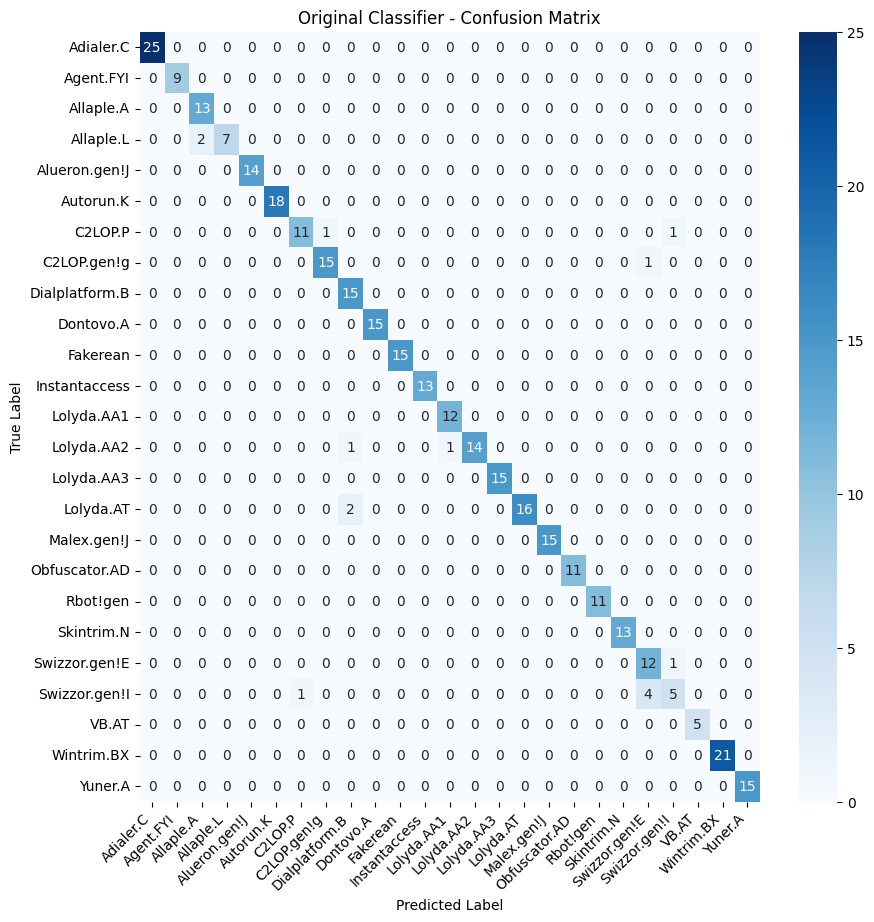

In [72]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Original Classifier - Confusion Matrix')
plt.show()

In [73]:
probabilities = []
true_labels = []

for img_batch, label_batch in zip(test_images, test_labels):
    probability_batch = stolen_classifier.predict(img_batch)
    probabilities.extend(probability_batch)
    true_labels.extend(label_batch)

probabilities = np.array(probabilities)
true_labels = np.array(true_labels)

predicted_labels = np.argmax(probabilities, axis=-1)

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


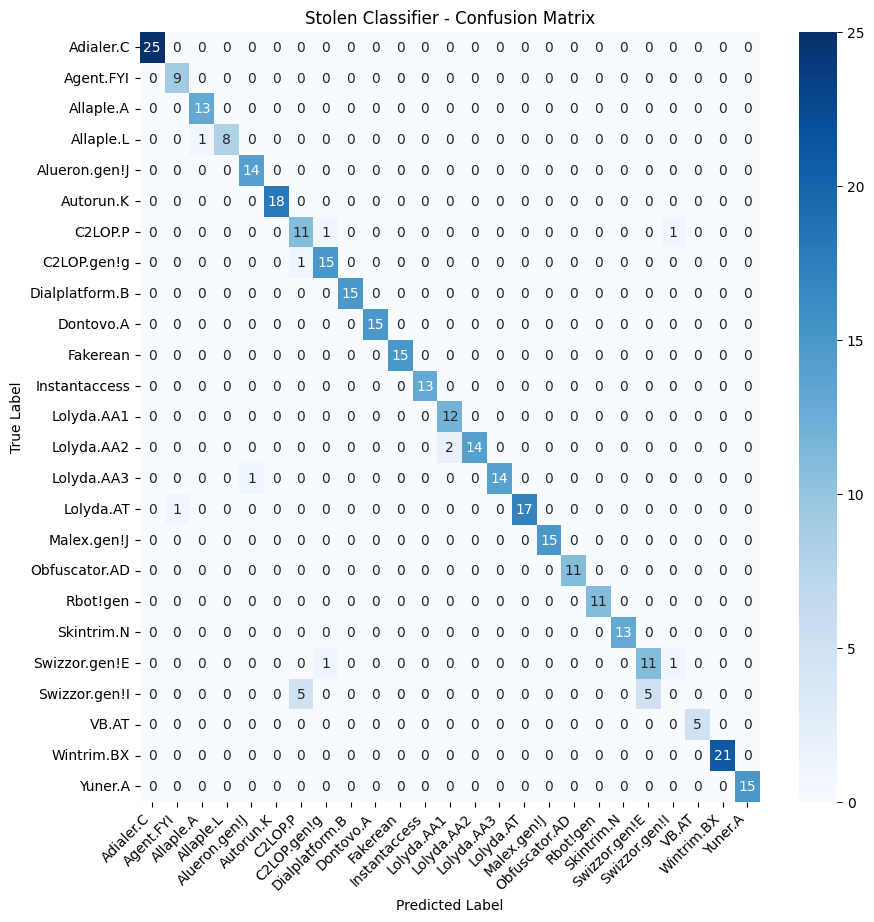

In [74]:
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Stolen Classifier - Confusion Matrix')
plt.show()

Se puede observar que el modelo copiado tiene un comportamiento muy similar al modelo original. Sin embargo, probablemente por haber sido entrenado con una menor cantidad de datos, el modelo copiado tuvo un peor desempeño. Este peor desempeño se destacaca con la clase Swizzor.gen!l; específicamente, algunos miembros de esta familia fueron erróneamente catalogados en otras clases como C2LOP.P y Swizzor.gen!E. 

En conclusión, si se ignoran los aspectos legales y éticos, el robo de modelos es un método económicamente rentable. Después de todo, el mayor costo para entrenar un modelo es conseguir los datos ya clasisficados. Entonces, al necesitar una menor cantidad de datos (incluso sin clasificar) reduce los costos de manera significativa. Asimismo, aunque el modelo robado desempeñe peor que el modelo original, todavía puede alcanzar métricas satisfactorias.

In [17]:
# save 
stolen_classifier.save("stolen_protected_cnn.h5")

## Ataque de Evasión

### Entrenamiento con Imágenes Adversariales

In [5]:
clasificador = KerasClassifier(
    model=vulnerable_model,
)

In [2]:
corrupted_data_location = "../malimg_paper_dataset_corrupted"
corrupted_images_location = '../corrupted_images'             # Actual location of the corrupted images
data_location = "../malimg_dataset/malimg_paper_dataset_imgs"
selected_images_location = '../malimg_paper_dataset_selected'

In [4]:
data = []
for family in os.scandir(data_location):
    if family.is_dir:
        for malware in os.scandir(family):
            data.append({ 
                "name": malware.name, 
                "path": malware.path,
                "family": family.name,
            })
    

df = pd.DataFrame(data, columns=["name", "path", "family"])

In [5]:
def get_stratified_sample(df, amount, seed=12345):
    return df.groupby('family', as_index=False, group_keys=False) \
                .apply(lambda s: s.sample(min(amount, len(s)), random_state=seed))

In [6]:
selected_df = get_stratified_sample(df, 70, seed=987654)
corrupted_df = get_stratified_sample(df, 30, seed=987654)

In [7]:
for _, row in selected_df.iterrows():
    os.makedirs(os.path.join(selected_images_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(selected_images_location, row['family'], row['name']))

In [9]:
for _, row in corrupted_df.iterrows():
    os.makedirs(os.path.join(corrupted_data_location, row['family']), exist_ok=True)
    os.symlink(os.path.abspath(row['path']), os.path.join(corrupted_data_location, row['family'], row['name']))

In [7]:
data_to_corrupt = image_dataset_from_directory(
    corrupted_data_location,
    image_size=(256, 256),
    shuffle=True,
    seed=191919,
)

data_to_corrupt_labels = []
data_to_corrupt_images = []
for image, label in tfds.as_numpy(data_to_corrupt):
    data_to_corrupt_labels.extend(label)
    data_to_corrupt_images.extend(image)

data_to_corrupt_labels = np.array(data_to_corrupt_labels)
data_to_corrupt_images = np.array(data_to_corrupt_images)

Found 750 files belonging to 25 classes.


In [9]:
attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.9,
)

corrupted_images = attack_fgsm.generate(x=np.array(data_to_corrupt_images))

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [13]:
# assuming 'corrupted_images' is your array
min_val = np.amin(corrupted_images)
max_val = np.amax(corrupted_images)

# normalizing to [0,1]
normalized_images = (corrupted_images - min_val) / (max_val - min_val)

In [14]:

#save test_images_mal into a folder based on labelf
for i in range(len(data_to_corrupt_labels)):
    os.makedirs(os.path.join(corrupted_images_location, data_to_corrupt.class_names[data_to_corrupt_labels[i]]), exist_ok=True)
    plt.imsave(os.path.join(corrupted_images_location, data_to_corrupt.class_names[data_to_corrupt_labels[i]], str(i) + ".png"), normalized_images[i])


In [15]:
del normalized_images, min_val, max_val 
del corrupted_data_location, data_to_corrupt, data_to_corrupt_images, data_to_corrupt_labels, corrupted_images

In [13]:
data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    seed=191919,
)
corrupted_images = image_dataset_from_directory(
    corrupted_images_location,
    image_size=(256, 256),
    shuffle=True,
    seed=191919,
)

Found 1750 files belonging to 25 classes.
Found 750 files belonging to 25 classes.


In [14]:
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15


train = data.take(int(train_ratio * len(data)))
validation = data.skip(len(train)).take(int(validation_ratio * len(data)))
test = data.skip(len(train) + len(validation)).take(int(test_ratio * len(data)))

In [16]:
train = train.concatenate(corrupted_images)

In [18]:
model = models.Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),     # normalize data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(data.class_names), activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [19]:
epochs=10
metrics = model.fit(train, validation_data=validation, epochs=epochs)

Epoch 1/10
62/62 [==============================] - 38s 604ms/step - loss: 1.5910 - accuracy: 0.5977 - val_loss: 0.6066 - val_accuracy: 0.7930
Epoch 2/10
62/62 [==============================] - 36s 579ms/step - loss: 0.3268 - accuracy: 0.8886 - val_loss: 0.2511 - val_accuracy: 0.9023
Epoch 3/10
62/62 [==============================] - 37s 586ms/step - loss: 0.1389 - accuracy: 0.9512 - val_loss: 0.1358 - val_accuracy: 0.9609
Epoch 4/10
62/62 [==============================] - 37s 594ms/step - loss: 0.0698 - accuracy: 0.9791 - val_loss: 0.0965 - val_accuracy: 0.9766
Epoch 5/10
62/62 [==============================] - 38s 604ms/step - loss: 0.0281 - accuracy: 0.9954 - val_loss: 0.0997 - val_accuracy: 0.9766
Epoch 6/10
62/62 [==============================] - 38s 605ms/step - loss: 0.0195 - accuracy: 0.9959 - val_loss: 0.2405 - val_accuracy: 0.9609
Epoch 7/10
62/62 [==============================] - 39s 635ms/step - loss: 0.0093 - accuracy: 0.9980 - val_loss: 0.0184 - val_accuracy: 0.9961

In [22]:
probabilities = []
true_labels = []

for img_batch, label_batch in test:
    probability_batch = model.predict(img_batch)
    probabilities.extend(probability_batch)
    true_labels.extend(label_batch.numpy())

probabilities = np.array(probabilities)
true_labels = np.array(true_labels)

1/1 [==============================] - 0s 128ms/step


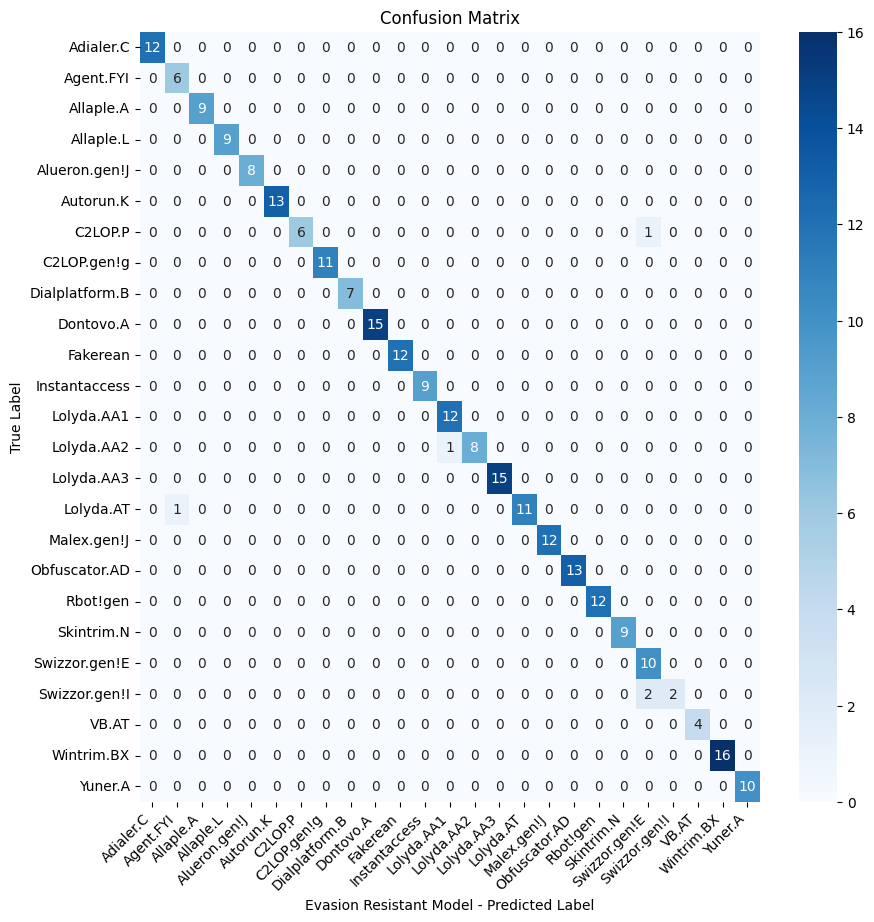

In [23]:
predicted_labels = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=data.class_names, yticklabels=data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Evasion Resistant Model - Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# save the model to an h5 file
model.save("evasion_resistant_model.h5")

# TODO hablar sobre el nuevo modelo resistente

In [26]:
tf.compat.v1.disable_eager_execution()

In [27]:
vulnerable_model = tf.keras.models.load_model("original_cnn.h5")
resistant_model = tf.keras.models.load_model("evasion_resistant_model.h5")

In [28]:
data_location = "../malimg_dataset/malimg_paper_dataset_imgs"
selected_images_location = '../model_copysotherselected'

test_data = image_dataset_from_directory(
    selected_images_location,
    image_size=(256, 256),
    shuffle=True,
    seed=191919,
)

test_labels = []
test_images = []
for image, label in tfds.as_numpy(test_data):
    test_labels.extend(label)
    test_images.extend(image)

test_images = np.array(test_images)
test_labels = np.array(test_labels)


Found 1750 files belonging to 25 classes.


In [30]:
clasificador = KerasClassifier(
    model=vulnerable_model
)

In [33]:
resistant_classifier = KerasClassifier(
    model=resistant_model
)

In [31]:
attack_fgsm = FastGradientMethod(
    estimator=clasificador, 
    eps=0.9,
)

In [32]:
test_images_mal = attack_fgsm.generate(x=np.array(test_images))

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


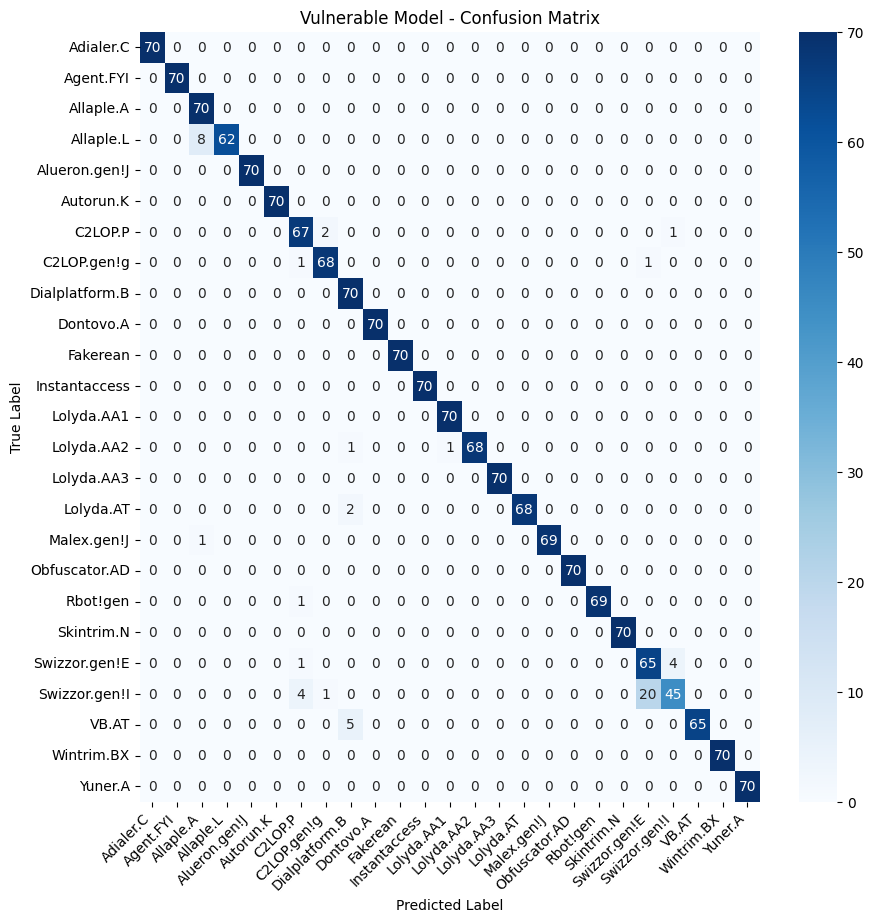

In [34]:
probabilities = clasificador.predict(test_images)
probabilities = np.array(probabilities)
predicted_labels = np.argmax(probabilities, axis=-1)

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Vulnerable Model - Confusion Matrix')
plt.show()

c:\Users\jjhh1\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


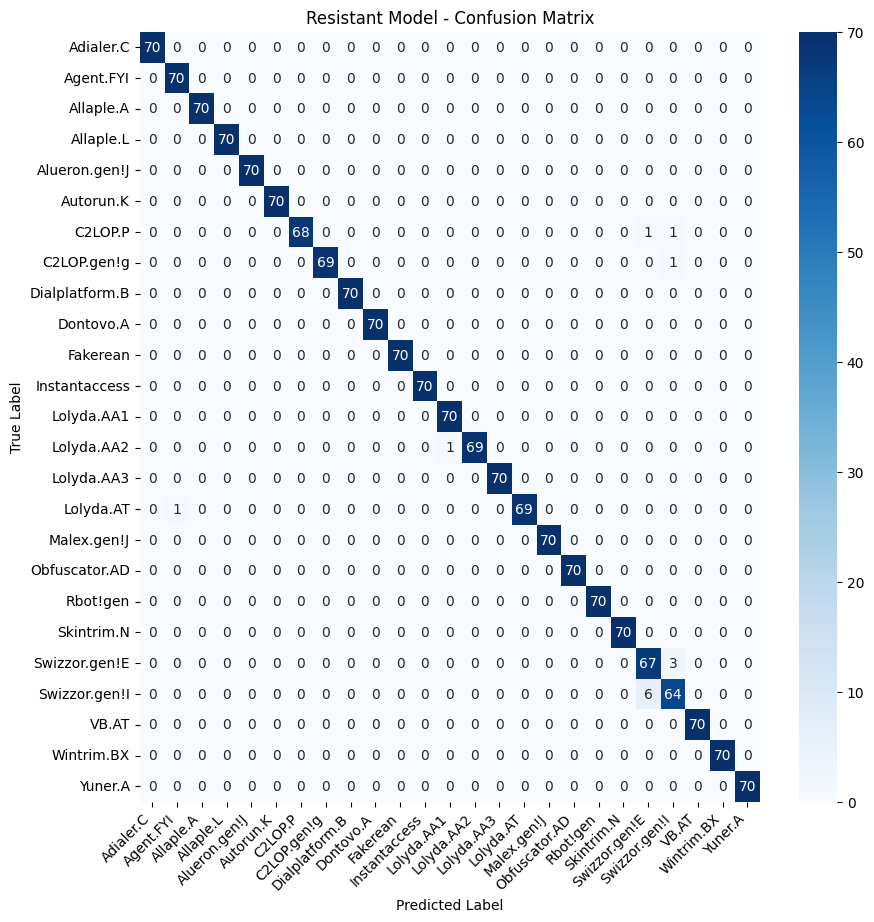

In [35]:
probabilities = resistant_classifier.predict(test_images)
probabilities = np.array(probabilities)
predicted_labels = np.argmax(probabilities, axis=-1)

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Resistant Model - Confusion Matrix')
plt.show()

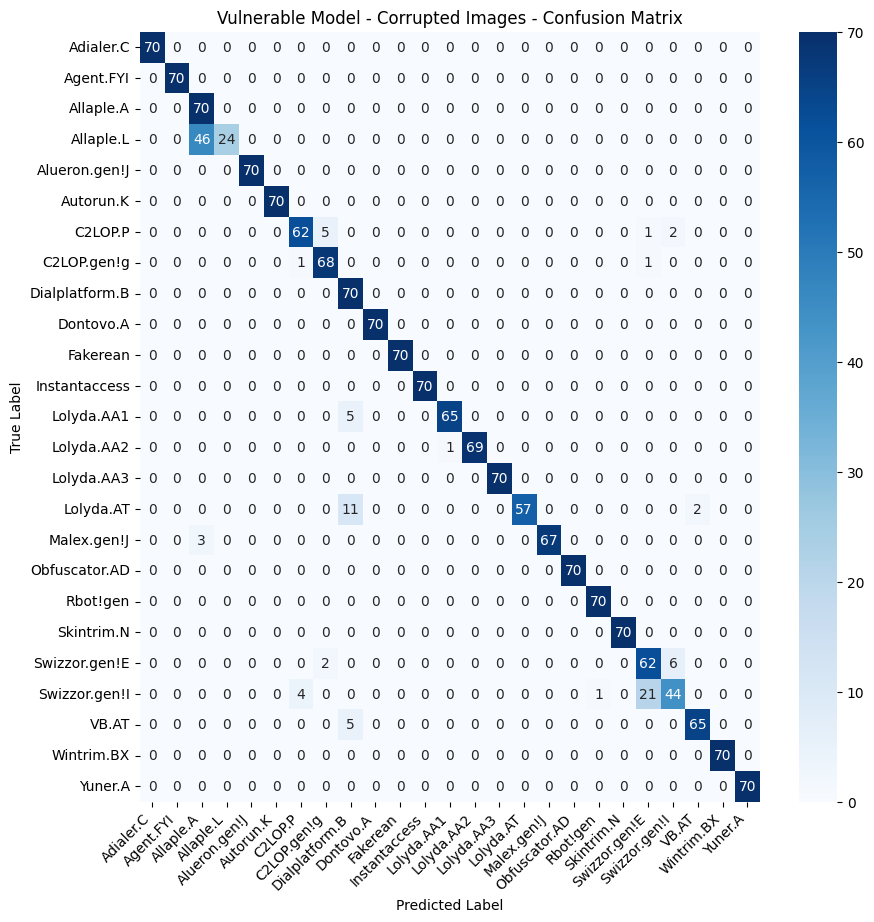

In [36]:
probabilities = clasificador.predict(test_images_mal)
probabilities = np.array(probabilities)
predicted_labels = np.argmax(probabilities, axis=-1)

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Vulnerable Model - Corrupted Images - Confusion Matrix')
plt.show()

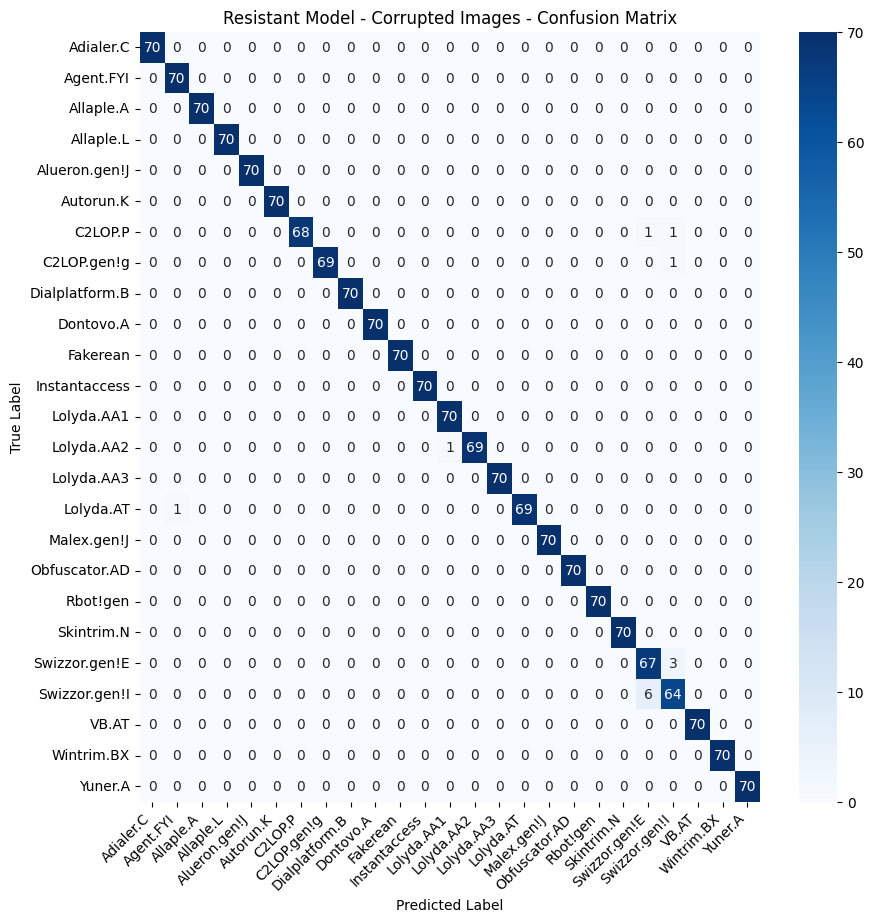

In [37]:
probabilities = resistant_classifier.predict(test_images_mal)
probabilities = np.array(probabilities)
predicted_labels = np.argmax(probabilities, axis=-1)

cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=test_data.class_names, yticklabels=test_data.class_names)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Resistant Model - Corrupted Images - Confusion Matrix')
plt.show()